In [1]:
import pathlib
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt


import SessionTools.two_photon as st2p


%load_ext autoreload
%autoreload 2 

%matplotlib inline

In [49]:
def get_stim_resp(pp,y):
    n_rois = y.shape[0]
    frame_times = np.array(pp.metadata['frame_times']).mean(axis=1)
    
    stim_times = [pp.metadata['mark_points']['initial_delay']]
    for i in range(pp.metadata['mark_points']['repetitions']-1):
        stim_times.append(pp.metadata['mark_points']['inter_point_delay']+pp.metadata['mark_points']['duration'])
    stim_times = np.array(stim_times)/1000
    stim_times = np.cumsum(stim_times)
    
    stim_inds = []
    for time in stim_times:
        stim_inds.append( np.argwhere((frame_times-time)>0)[0][0])
    stim_inds = np.array(stim_inds)
    
    y[:, stim_inds]=np.nan
    y[:, stim_inds-1]=np.nan
    y[:, stim_inds+1]=np.nan
    
    stim_resp = np.zeros((len(stim_inds)-1, n_rois, 50))
    for i, ind in enumerate(stim_inds[1:]):
        stim_resp[i,:,:] = y[:, ind-10:ind+40]
    stim_resp /= np.nanmean(stim_resp[:,:,:10], axis=-1, keepdims=True)
    
    return stim_resp

In [78]:

bruker_folder = pathlib.PurePath('/media/mplitt/SSD_storage/2PData')
fictrac_folder = pathlib.PurePath('/media/mplitt/SSD_storage/fictrac_folder')
                            

# sessions = ['baseline_stim-001', 'DA_washon_stim-002', 'post_DA_washon_stim-003', 'OA_washon_stim-004', 'post_OA_washon_stim-006']
# sessions = ['baseline_stim-001', 'DA_washon_stim-002', 'OA_washon_stim-004']
sessions = ['baseline_stim-000', 'post_DA_washon_stim-003', 'post_OA_washon_stim-005']
# sessions = ['baseline_stim-001', 'post_DA_washon_stim-003', 'post_OA_washon_stim-006']


gd = 'ER4d_Chrimson88tdT_sytjGCaMP7f'
d = '19_02_2024'
f = 'fly2'

stim_resp_list = []
for s in sessions:
    outdir = pathlib.PurePath(f'/media/mplitt/SSD_storage/2P_scratch/{gd}/{d}/{f}/{s}/preprocess.pkl')
    pp = st2p.preprocessing.EBImagingSession.from_file(outdir)
    y = pp.calculate_zscored_F('rois', exp_detrend=True,zscore=False)[1,:,:]
    
    stim_resp_list.append(get_stim_resp(pp,y))

/tmp/ipykernel_601803/4087554673.py:6: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(np.nanmean(sr,axis=0),axis=0)
/tmp/ipykernel_601803/4087554673.py:7: RuntimeWarning: Mean of empty slice
  sem = sp.stats.sem(np.nanmean(sr, axis=1),axis=0, nan_policy='omit')


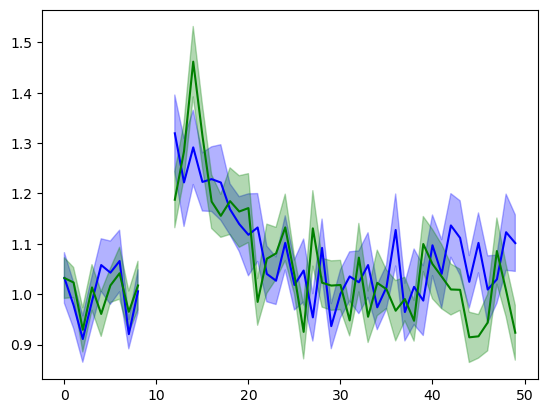

In [79]:
fig, ax = plt.subplots()

x = np.arange(50)
colors = ['blue', 'green','red']
for i, sr in enumerate(stim_resp_list[1:]):
    mu = np.nanmean(np.nanmean(sr,axis=0),axis=0)
    sem = sp.stats.sem(np.nanmean(sr, axis=1),axis=0, nan_policy='omit')
    
    ax.plot(x, mu, color= colors[i])
    ax.fill_between(x, mu-sem, mu+sem, color= colors[i], alpha=.3)

80.0 0.045679688453674316
[0.19346623747142733, 0.10332782819901776, 0.20511549955631136]
80.0 0.02499643485669719


/tmp/ipykernel_601803/485595764.py:3: RuntimeWarning: Mean of empty slice
  r = np.nanmean(sr[:,:,:30], axis=1).mean(axis=-1)-1


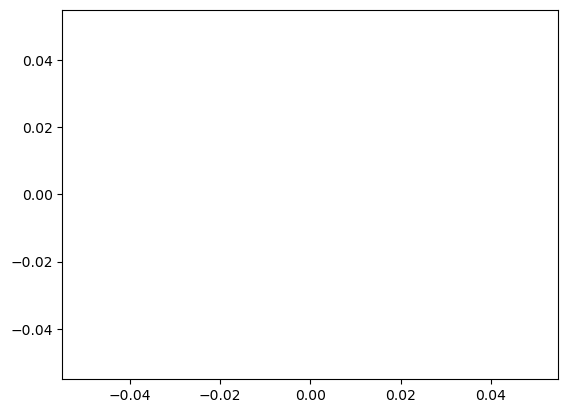

In [77]:
fig, ax = plt.subplots()
for i, sr in enumerate(stim_resp_list):
    r = np.nanmean(sr[:,:,:30], axis=1).mean(axis=-1)-1
    ax.scatter(np.zeros_like(r)+i, r)

t, p = sp.stats.wilcoxon(stim_resp_list[0][:,:,12:30].mean(axis=1).mean(axis=-1),stim_resp_list[1][:,:,12:30].mean(axis=1).mean(axis=-1))
print(t,p)
print([sr[:,:,12:17].mean(axis=1).mean(axis=-1).mean()-1 for sr in stim_resp_list])

f, p = sp.stats.kruskal(stim_resp_list[0][:,:,12:30].mean(axis=1).mean(axis=-1),stim_resp_list[1][:,:,12:30].mean(axis=1).mean(axis=-1),stim_resp_list[2][:,:,12:30].mean(axis=1).mean(axis=-1))
print(t,p)

In [ ]:
# 